In [121]:
!pip install icecream category_encoders tomli tomli_w zero sdmetrics prdc

In [2]:
!pip install synthcity

In [122]:
!pip install -U kaleido

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd 'drive/MyDrive/Thesis (masters)'

/content/drive/MyDrive/Thesis (masters)


In [5]:
# !python download_dataset.py
# !python process_dataset.py

### Обучение модели и семплирование

In [7]:
!python main.py --dataname adult --method tabddpm --mode train

In [6]:
!python main.py --dataname adult --method tabddpm --mode sample --save_path './generated_samples/adult.csv'

START SAMPLING
No NaNs in numerical features, skipping
mlp
torch.Size([10000, 104])

torch.Size([10000, 104])

torch.Size([10000, 104])
Sample timestep    0
torch.Size([10000, 104])
Sample timestep    0
Shape torch.Size([32561, 15])
(32561, 9)
Sampling time: 230.52300214767456


### Расчет готовых метрик из репозитория TabSyn

In [120]:
!python eval/eval_density.py --dataname adult --model tabddpm --path './generated_samples/adult.csv'

./generated_samples/adult.csv
Generating report ...

(1/2) Evaluating Column Shapes: 100% 15/15 [00:00<00:00, 104.05it/s]
Column Shapes Score: 98.67%

(2/2) Evaluating Column Pair Trends: 100% 105/105 [00:01<00:00, 53.17it/s]
Column Pair Trends Score: 97.38%

Overall Score (Average): 98.03%

Generating report ...

(1/2) Evaluating Data Validity: 100% 15/15 [00:00<00:00, 143.85it/s]
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: 100% 1/1 [00:00<00:00, 450.71it/s]
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [8]:
!python eval/eval_quality.py --dataname adult --model tabddpm --path './generated_samples/adult.csv'

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK
E0000 00:00:1742035866.783381   24195 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742035866.870097   24195 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
./generated_samples/adult.csv
=========== All Features ===========
Data shape:  (32561, 110)
alpha precision: 0.940700, beta recall: 0.501512


In [9]:
!python eval/eval_mle.py --dataname adult --model tabddpm --path './generated_samples/adult.csv'

100% 36/36 [00:18<00:00,  1.95it/s]
Saving scores to  eval/mle/adult/tabddpm.json


In [10]:
import json
from pprint import pprint

with open('./eval/mle/adult/tabddpm.json', 'r') as file:
    data = json.load(file)
pprint(data)

{'best_acc_scores': {'XGBClassifier': {'accuracy': 0.858055402002334,
                                       'binary_f1': 0.6671467665274378,
                                       'roc_auc': 0.910852339602229,
                                       'weighted_f1': 0.724466303748754}},
 'best_auroc_scores': {'XGBClassifier': {'accuracy': 0.858055402002334,
                                         'binary_f1': 0.6671467665274378,
                                         'roc_auc': 0.910852339602229,
                                         'weighted_f1': 0.724466303748754}},
 'best_avg_scores': {'XGBClassifier': {'accuracy': 0.858055402002334,
                                       'binary_f1': 0.6671467665274378,
                                       'roc_auc': 0.910852339602229,
                                       'weighted_f1': 0.724466303748754}},
 'best_f1_scores': {'XGBClassifier': {'accuracy': 0.858055402002334,
                                      'binary_f1': 0.667146766527

In [12]:
!python eval/eval_dcr.py --dataname adult --model tabddpm --path './generated_samples/adult.csv'

DCR Score, a value closer to 0.5 is better
adult-tabddpm, DCR Score = 0.6752556739657873


### Метрики из статьи TabSyn (расширение метрик из репозитория)

In [23]:
!python eval/eval_mle.py --dataname adult --model tabddpm --path './generated_samples/adult.csv'

100% 36/36 [00:17<00:00,  2.01it/s]
Saving scores to  eval/mle/adult/tabddpm.json
ROC - AUC обучения на синтетических данных TABDDPM: 0.907 ± 0.006


In [116]:
!python eval/eval_tabsyn_metrics.py --dataname adult --model tabddpm --path './generated_samples/adult.csv'

./generated_samples/adult.csv
CALCULATING COLUMN-WISE DENSITY ESTIMATION & PAIR-WISE COLUMN CORRELATION...
Generating report ...

(1/2) Evaluating Column Shapes: 100% 15/15 [00:00<00:00, 90.75it/s]
Column Shapes Score: 98.67%

(2/2) Evaluating Column Pair Trends: 100% 105/105 [00:01<00:00, 73.60it/s]
Column Pair Trends Score: 97.38%

Overall Score (Average): 98.03%

DONE!
DRAW COLUMN VALUES DISTRIBUTIONS...
DONE


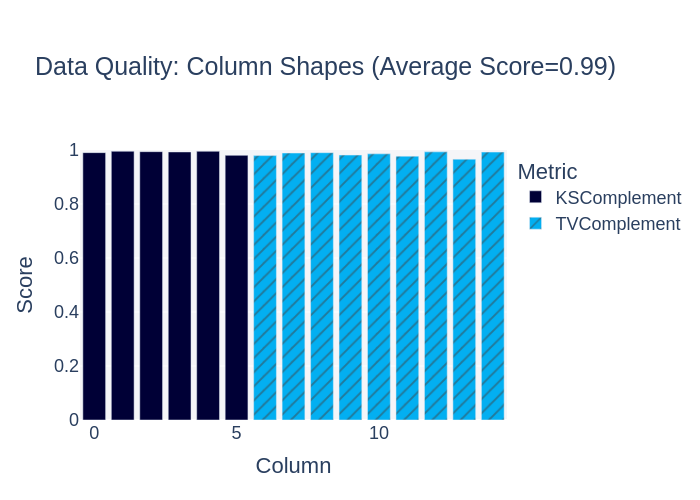

In [29]:
from PIL import Image
im = Image.open("./eval/tabsyn_metrics/adult/tabddpm/column-wise-density-estimation.png")
im

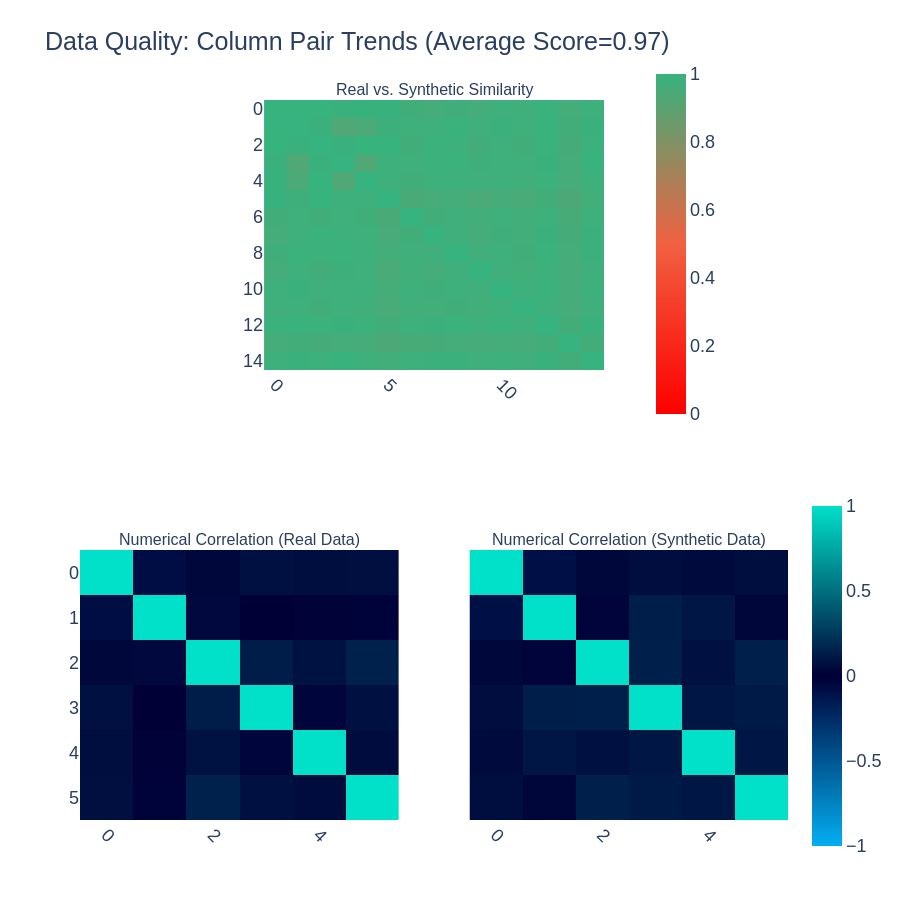

In [30]:
im = Image.open("./eval/tabsyn_metrics/adult/tabddpm/pair-wise-column-correlation.png")
im

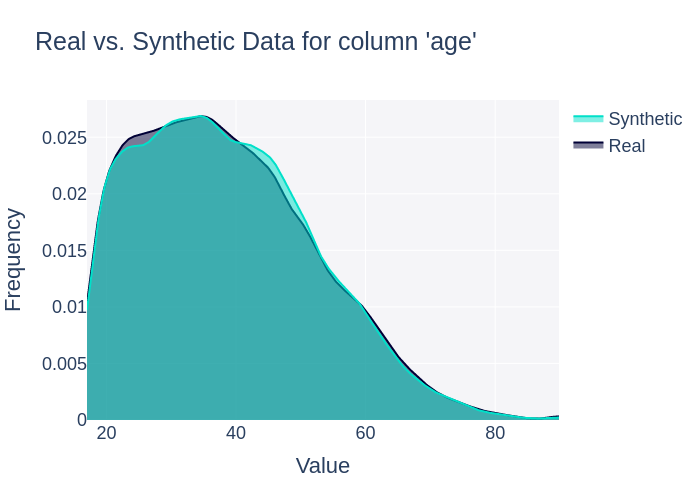

In [118]:
im = Image.open("./eval/tabsyn_metrics/adult/tabddpm/distribution-of-age.png")
im

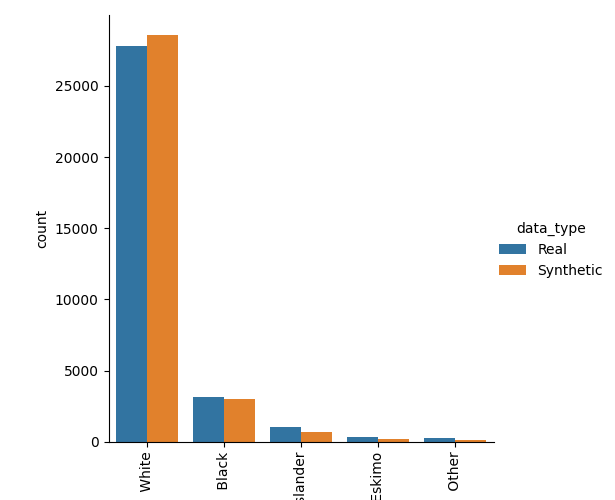

In [119]:
im = Image.open("./eval/tabsyn_metrics/adult/tabddpm/distribution-of-race.png")
im